In [1]:
import os
import zlib
import numpy as np
import PIL.Image as Image
from IPython.display import display

import torch
import torch.nn as nn
from torchvision import transforms

import compressai
from compressai.entropy_models import EntropyBottleneck
from compressai.layers import GDN
from compressai.models import CompressionModel
from compressai.models.utils import conv, deconv

In [2]:
def pil_to_pt(img):
    t = transforms.functional.pil_to_tensor(img)
    t = t.to(torch.float)
    t = t/255
    t = t-0.5
    t = t.unsqueeze(0)
    return t
def pt_to_pil(t):
    t = t+0.5
    t = t*255
    t = torch.clamp(t, min=-0.49, max=255.49)
    t = t.round()
    t = t.to(torch.uint8)
    return t

In [3]:
class RateDistortionAutoEncoder(CompressionModel):
    def __init__(self, N=128):
        super().__init__()
        self.entropy_bottleneck = EntropyBottleneck(N)
        self.encode = nn.Sequential(
            conv(3, N),
            GDN(N),
            conv(N, N),
            GDN(N),
            conv(N, N),
        )

        self.decode = nn.Sequential(
            deconv(N, N),
            GDN(N, inverse=True),
            deconv(N, N),
            GDN(N, inverse=True),
            deconv(N, 3),
        )

    def forward(self, x):
        y = self.encode(x)
        y_hat, y_likelihoods = self.entropy_bottleneck(y)
        x_hat = self.decode(y_hat)
        return x_hat, y_likelihoods

In [8]:
def lossy_analysis_transform(img):
    x = pil_to_pt(img)
    z = net.encode(x).round().to(torch.int8).detach().numpy()
    return z
    
def lossless_entropy_encode(z):
    original_shape = z.shape
    compressed_img = zlib.compress(z.tobytes(), level=9)
    return compressed_img, original_shape

def compress(img):
    z = lossy_analysis_transform(img)
    compressed_img, original_shape = lossless_entropy_encode(z)
    return compressed_img, original_shape

In [9]:
def entropy_decoder(compressed_img,original_shape):
    decompressed = zlib.decompress(compressed_img)
    ẑ = np.frombuffer(decompressed, dtype=np.int8)
    ẑ = ẑ.reshape(original_shape)
    return ẑ
    
def synthesis_transform(ẑ):
    ẑ = torch.tensor(ẑ).to(torch.float)
    x̂ = net.decode(ẑ).detach()
    return x̂
    
def decompress(compressed_img, original_shape):
    ẑ = entropy_decoder(compressed_img,original_shape)
    x̂ = synthesis_transform(ẑ)
    return x̂

In [6]:
net = RateDistortionAutoEncoder()
net = net
checkpoint = torch.load("checkpoint.pth")
net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [7]:
img = Image.open("test.jpg");
img.save("test_q5.jpg", "JPEG", quality=5)
jpeg = Image.open("test_q5.jpg");

In [10]:
compressed_img, original_shape = compress(img);
print("Bytes in compressed image:", len(compressed_img))
x̂ = decompress(compressed_img, original_shape)

Bytes in compressed image: 60438


original image


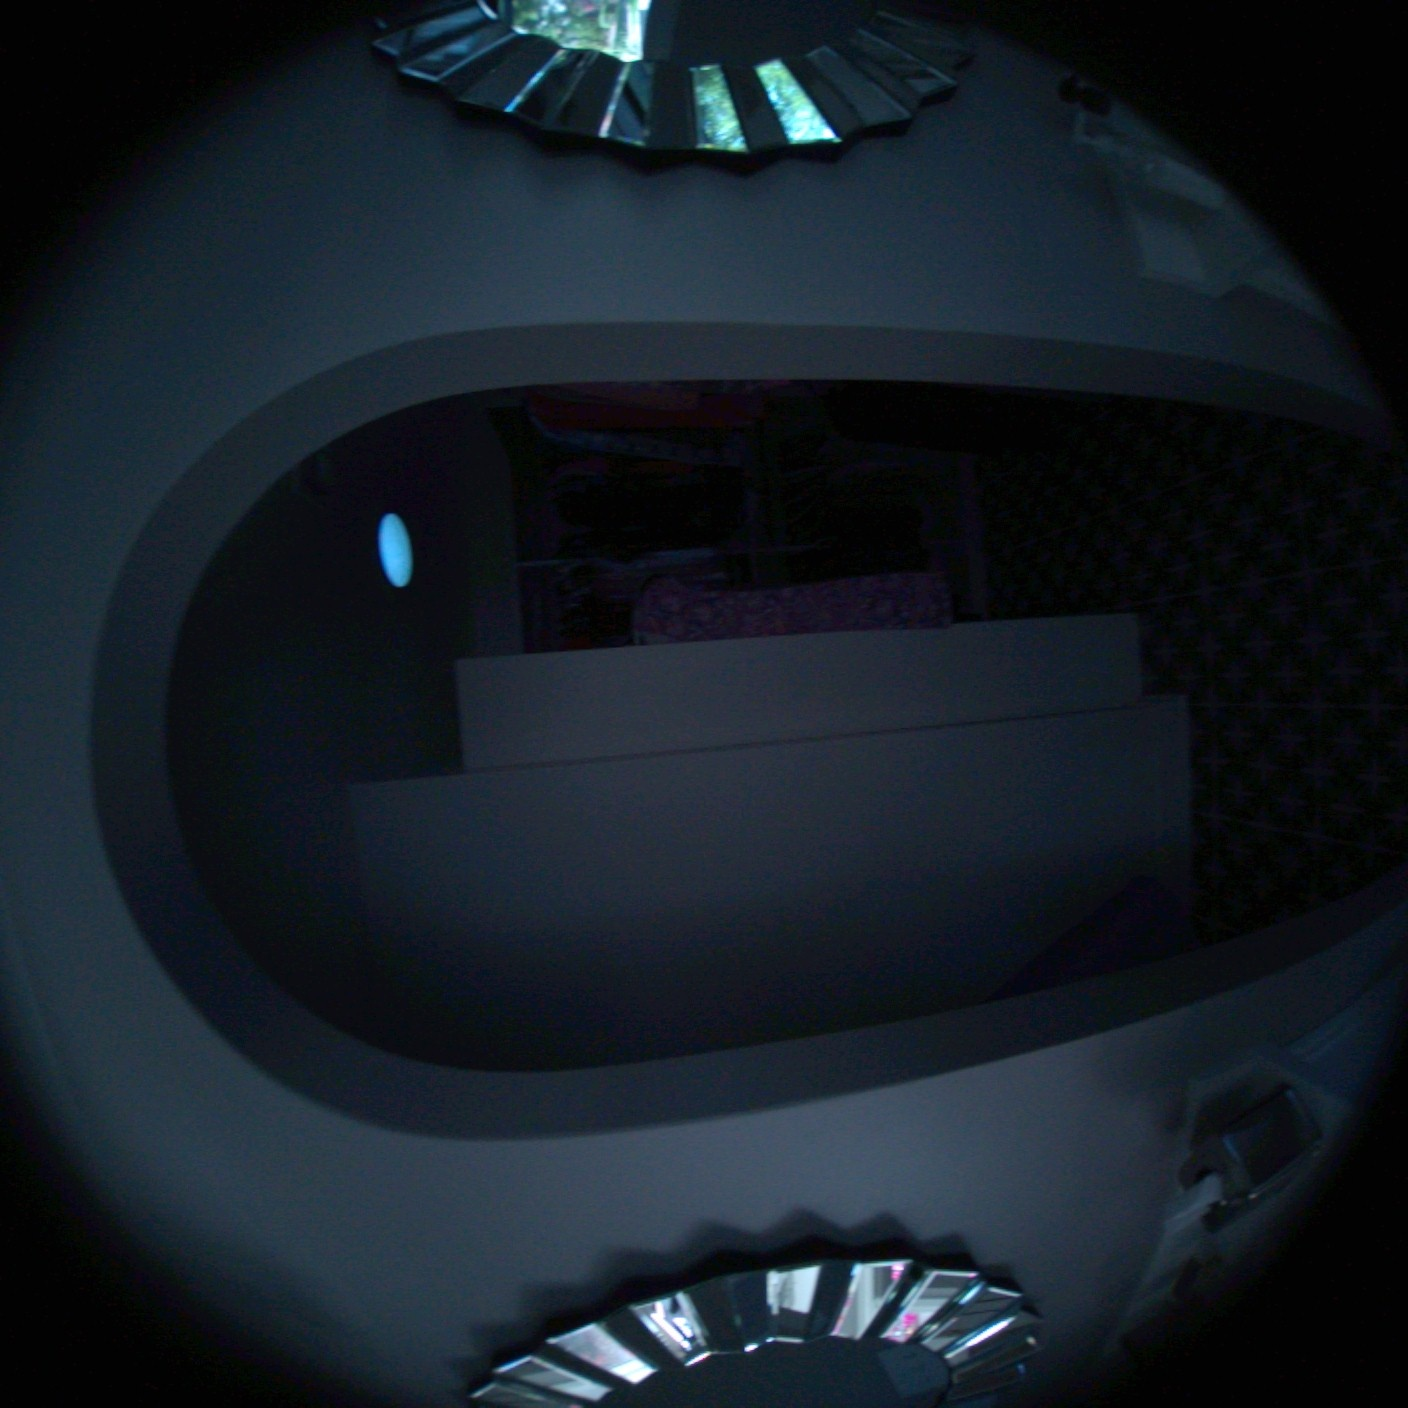

JPEG compression ratio 35.07308081108402


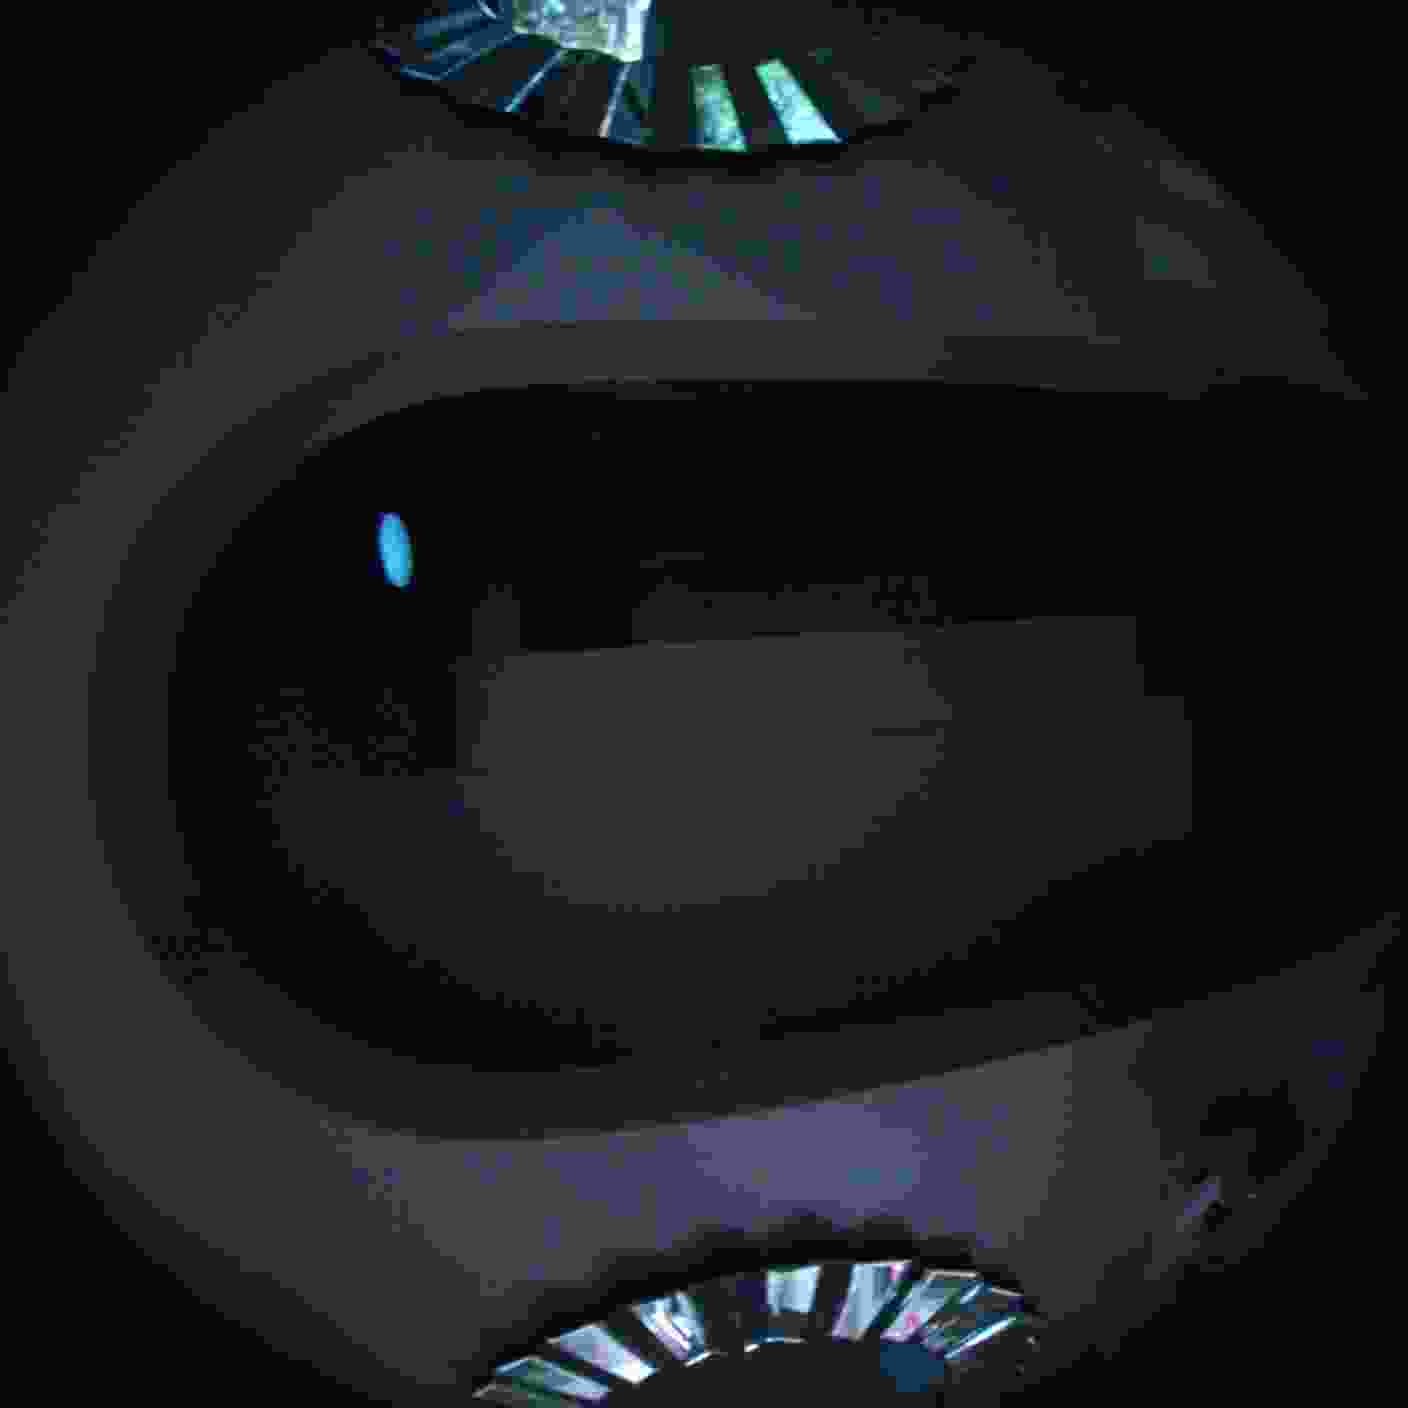

RDAE compression ratio 19.518316291075152


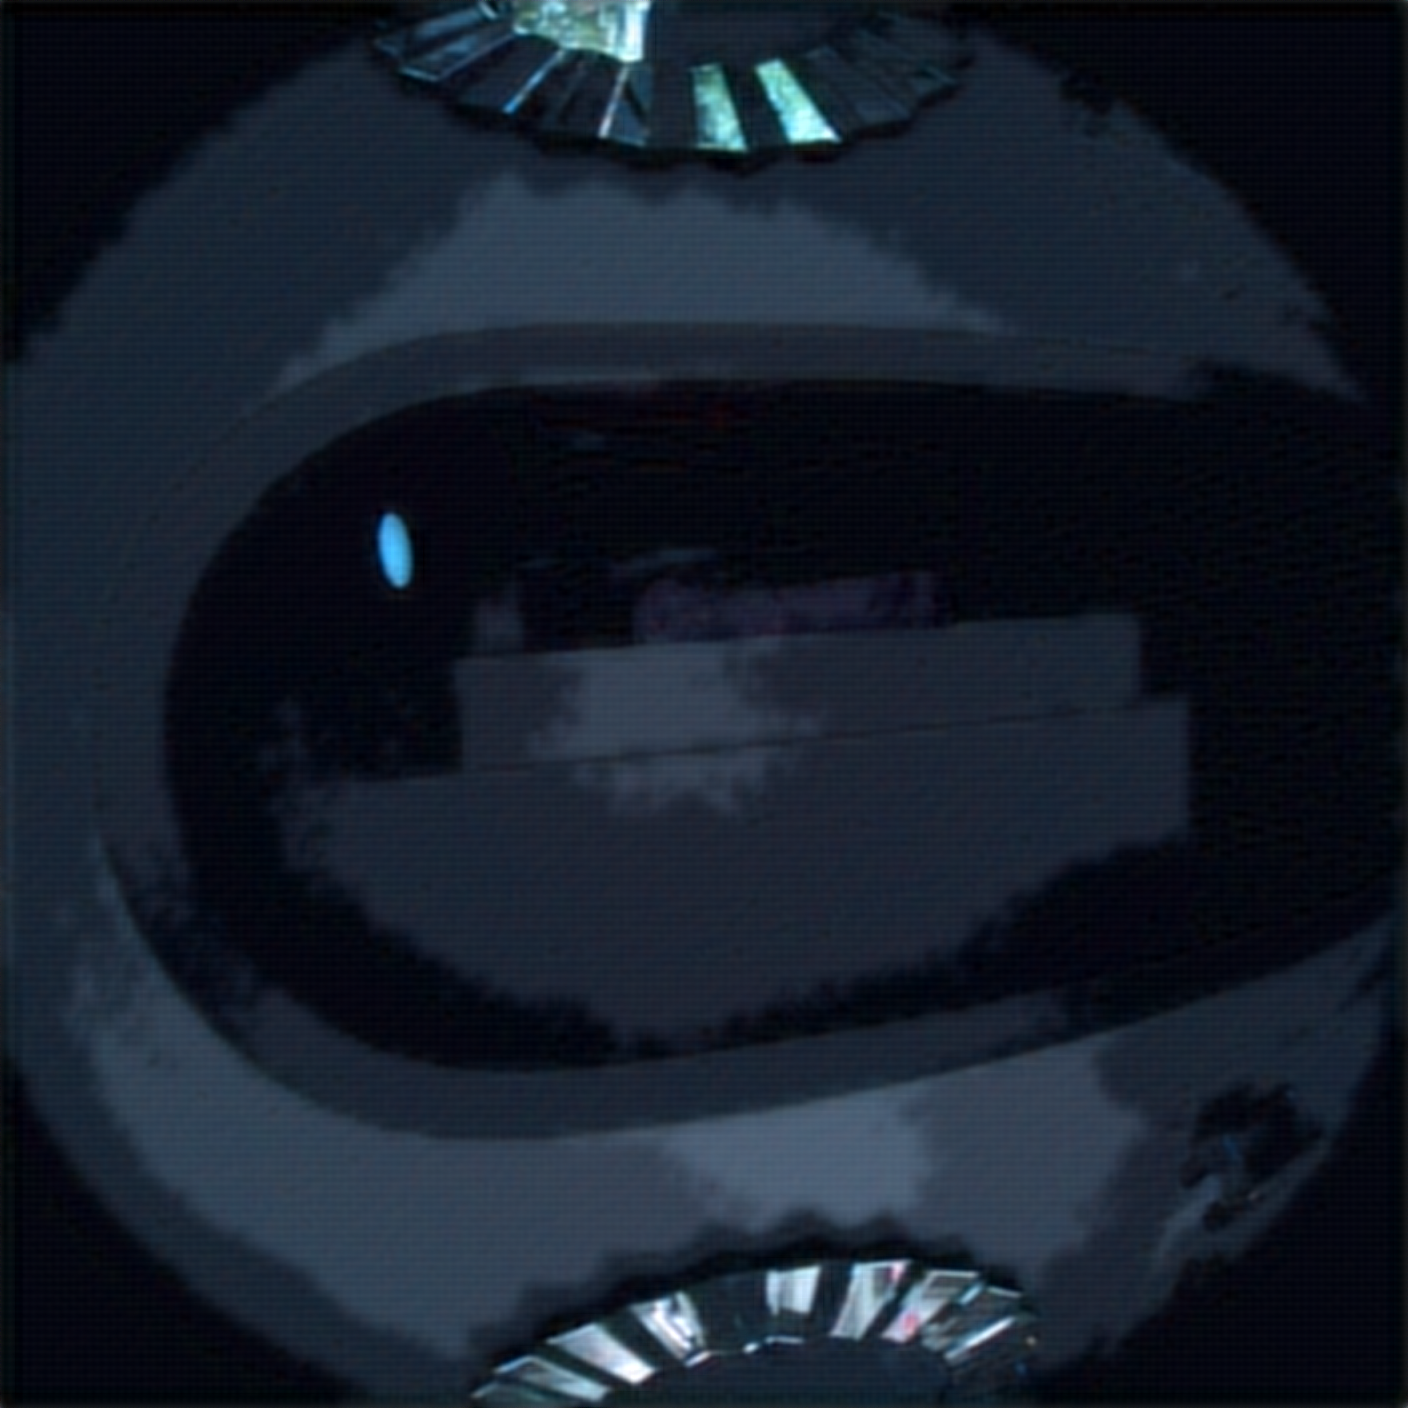

In [12]:
print('original image');
display(img)
print("JPEG compression ratio", (3*512*768)/os.path.getsize('test_q5.jpg'))
display(jpeg);
print("RDAE compression ratio", (3*512*768)/len(compressed_img))
display(transforms.ToPILImage()(pt_to_pil(x̂)[0]))

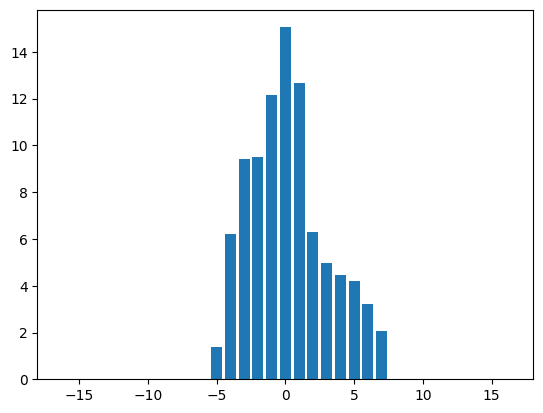

In [13]:
import matplotlib.pyplot as plt
z = lossy_analysis_transform(img)
histogram = torch.histogram(torch.tensor(z).to(torch.float),bins=33, range=(-16.5,16.5))
x = np.convolve(histogram.bin_edges,[0.5,0.5])[1:-1]
y = np.log(1+histogram.hist)
plt.bar(x,y);